In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from mip import Model, maximize, xsum, BINARY
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Load parameters

In [2]:
from scipy.stats import norm

weights = np.array([-1, -0.5, 0, 0.5, 1])
stan_model = '3pl_m2'

## Load StanFit.
f = os.path.join('stan_results', f'{stan_model}_summary.tsv')
params = read_csv(f, sep='\t', index_col=0)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## Extract parameters.
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values
gamma = 0.25

mu = np.outer(weights, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
q = 1 - p

W = np.square(alpha) * (q / p) * np.square((p - gamma) / (1 - gamma))
W = W.T

theta = np.linspace(-3,3,1001)
mu = np.outer(theta, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)
prior = norm(0,1).pdf(theta)
P = (prior @ p) / prior.sum()

## Assembly #1

In [3]:
## Define indices.
triples = []
for i in range(0, len(beta), 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12
tol = 5e-2

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

[ 51  93 124 131 149 189 243 254 293 304 334 359]


[1.83 3.09 3.84 3.6  2.65]
[1.95 2.95 3.37 3.19 2.6 ]
[1.71 3.06 3.96 3.77 2.78]


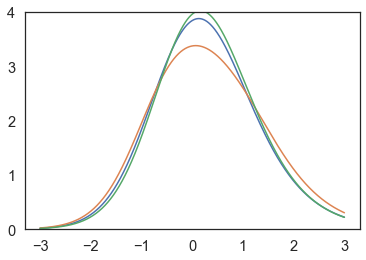

In [4]:
for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,3001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
    print(I[np.in1d(theta, [-1,-0.5,0,0.5,1])].sum(axis=1).round(2))
plt.ylim(0,4);

[51, 93, 125, 130, 148, 189, 243, 253, 292, 305, 335, 358]
[52, 94, 123, 131, 149, 190, 244, 254, 293, 303, 333, 359]
[53, 95, 124, 129, 147, 191, 245, 252, 291, 304, 334, 357]


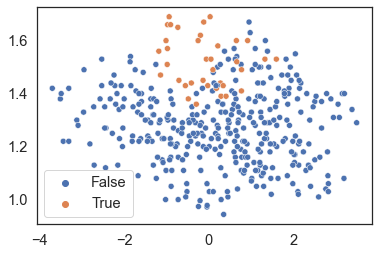

In [5]:
for i in range(3):
    print([triples[j][i] for j in selected])
    
sns.scatterplot(
    x=beta,
    y=alpha,
    hue =np.in1d(np.arange(n_item), np.concatenate([triples[i] for i in selected]))
);

0.65 0.08
0.64 0.25
0.64 0.08


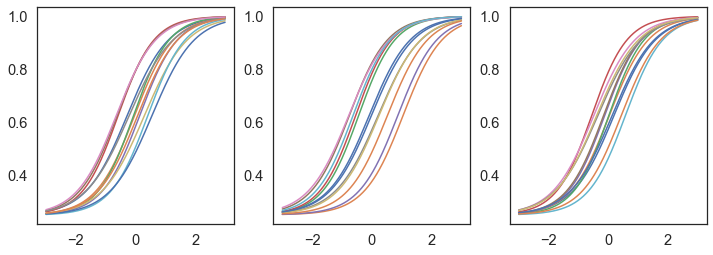

In [6]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    print(np.mean(p[theta==0]).round(2), np.mean(p[theta==0] < 0.5).round(2))
    ax.plot(theta, p)

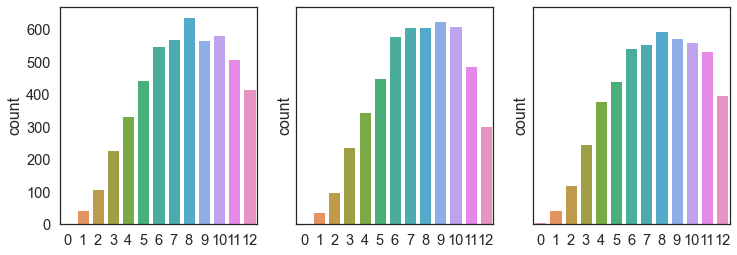

In [7]:
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
np.random.seed(47404)

for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    theta = np.random.normal(0,1,5000)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    y = np.random.binomial(1,p)
    sns.countplot(x=y.sum(axis=1), ax=ax)

## Assembly #2

In [8]:
## Define indices.
triples = []
for i in range(0, len(beta), 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12
tol = 5e-2

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Constraint #3: minimize differences.
for k in range(W.shape[1]):
    model += xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j2,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j2,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j3,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j3,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
        
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

[ 53  94 124 130 149 191 245 254 291 304 334 358]


[1.85 3.02 3.73 3.55 2.66]
[1.81 3.06 3.74 3.51 2.68]
[1.82 3.02 3.7  3.5  2.69]


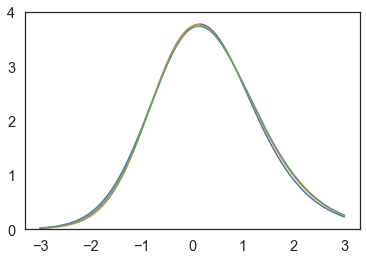

In [9]:
for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,3001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
    print(I[np.in1d(theta, [-1,-0.5,0,0.5,1])].sum(axis=1).round(2))
plt.ylim(0,4);

[52, 95, 125, 131, 148, 190, 244, 253, 291, 305, 335, 359]
[53, 93, 123, 129, 149, 191, 245, 254, 292, 303, 333, 357]
[51, 94, 124, 130, 147, 189, 243, 252, 293, 304, 334, 358]


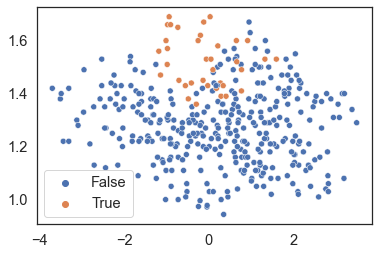

In [10]:
for i in range(3):
    print([triples[j][i] for j in selected])
    
sns.scatterplot(
    x=beta,
    y=alpha,
    hue =np.in1d(np.arange(n_item), np.concatenate([triples[i] for i in selected]))
);

0.6428360525553838 0.17
0.6331000934573884 0.08
0.6347446087405016 0.17


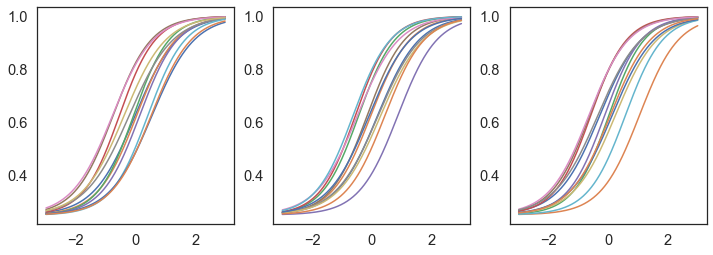

In [11]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    print(P[ix].mean(), np.mean(p[theta==0] < 0.5).round(2))
    ax.plot(theta, p)


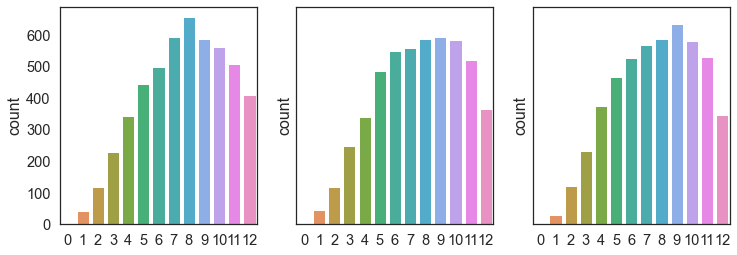

In [12]:
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
np.random.seed(47404)

for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    theta = np.random.normal(0,1,5000)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    y = np.random.binomial(1,p)
    sns.countplot(x=y.sum(axis=1), ax=ax)

## Assembly #3

In [41]:
## Define indices.
triples = []
for i in range(0, len(beta), 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
    
## Define metadata.
n_item = len(triples)
n_test = 12
tol = 5e-2

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_item)]

## Define objective.
model.objective = maximize(xsum(x[i] * W[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
model += xsum(x[i] for i in range(n_item)) <= n_test

## Constraint #2: one set per family.
for i in range(0,n_item,6): 
    model += xsum(x[i:i+6]) <= 1

## Constraint #3: minimize differences.
for k in range(W.shape[1]):
    model += xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j2,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j2,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j3,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
    model += xsum(x[i] * W[j3,k] for i, (j1,j2,j3) in enumerate(triples)) -\
             xsum(x[i] * W[j1,k] for i, (j1,j2,j3) in enumerate(triples)) <= tol
        
## Constraint #4: kill me
model += xsum(x[i] * P[j1] for i, (j1,j2,j3) in enumerate(triples)) / n_test <= 0.6
model += xsum(x[i] * P[j2] for i, (j1,j2,j3) in enumerate(triples)) / n_test <= 0.6
model += xsum(x[i] * P[j3] for i, (j1,j2,j3) in enumerate(triples)) / n_test <= 0.6
        
## Optimize.
model.optimize(max_seconds=120)

selected = np.array([i for i in range(n_item) if x[i].x])
print(selected)

[ 53  94 124 130 149 191 245 254 291 304 334 358]


[1.85 3.02 3.73 3.55 2.66]
[1.81 3.06 3.74 3.51 2.68]
[1.82 3.02 3.7  3.5  2.69]


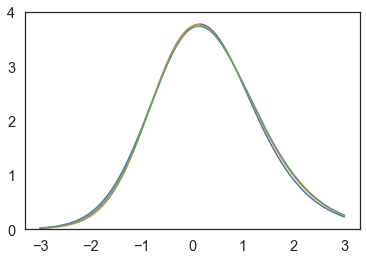

In [47]:
for i in range(3):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,3001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    q = 1 - p
    I = np.square(alpha[ix]) * (q / p) * np.square((p - gamma) / (1 - gamma))
    plt.plot(theta, I.sum(axis=1))
    print(I[np.in1d(theta, [-1,-0.5,0,0.5,1])].sum(axis=1).round(2))
plt.ylim(0,4);

[52, 95, 125, 131, 148, 190, 244, 253, 291, 305, 335, 359]
[53, 93, 123, 129, 149, 191, 245, 254, 292, 303, 333, 357]
[51, 94, 124, 130, 147, 189, 243, 252, 293, 304, 334, 358]


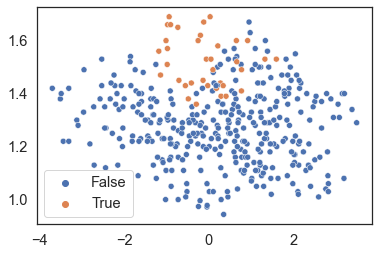

In [48]:
for i in range(3):
    print([triples[j][i] for j in selected])
    
sns.scatterplot(
    x=beta,
    y=alpha,
    hue =np.in1d(np.arange(n_item), np.concatenate([triples[i] for i in selected]))
);

0.6428360525553838 0.17
0.6331000934573884 0.08
0.6347446087405016 0.17


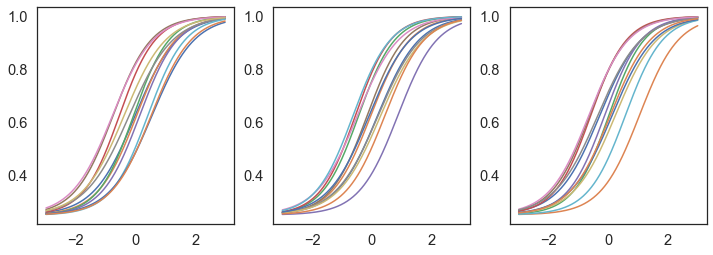

In [49]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    print(P[ix].mean(), np.mean(p[theta==0] < 0.5).round(2))
    ax.plot(theta, p)

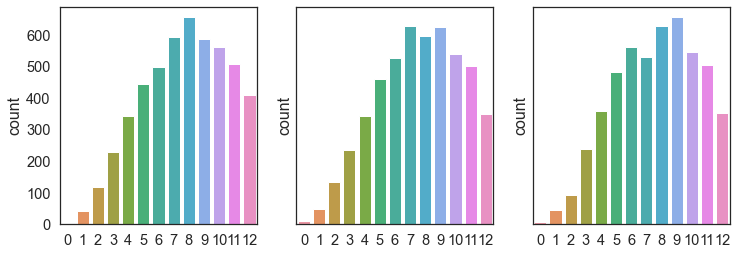

In [50]:
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
np.random.seed(47404)
theta = np.random.normal(0,1,5000)
for i, ax in enumerate(axes):
    ix = [triples[j][i] for j in selected]
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    y = np.random.binomial(1,p)
    sns.countplot(x=y.sum(axis=1), ax=ax)

In [53]:
from cmdstanpy import CmdStanModel

StanModel = CmdStanModel(stan_file='stan_models/tetrachoric.stan')

Y = y[:500].copy()
J, K = Y.shape
dd = dict(J=J, K=K, Y=Y)

StanFit = StanModel.optimize(data=dd, seed=0)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/szoro/Desktop/projects/mars-irt/03_Calibration/stan_models/tetrachoric
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [54]:
StanFit.optimized_params_pd

,lp__,mu[1],mu[2],mu[3],mu[4],mu[5],mu[6],mu[7],mu[8],mu[9],...,"Omega[4,12]","Omega[5,12]","Omega[6,12]","Omega[7,12]","Omega[8,12]","Omega[9,12]","Omega[10,12]","Omega[11,12]","Omega[12,12]",S
0,-41940.8,0.473176,-0.156038,0.263639,0.58867,0.369078,0.55331,0.712587,0.401452,0.242931,...,0.265427,0.247253,0.366673,0.238765,0.308188,0.333285,0.245387,0.271512,1.0,0.286026
